In [1]:
def inv(matrix):
    '''matrix inversion function robust to 1x1 matricies'''
    if len(matrix.to_numpy().ravel()) == 1:
        return 1 / matrix
    elif len(matrix.to_numpy().ravel()) > 1:
        return np.linalg.inv(matrix)
    else:
        Exception('Input matrix must have >1 obs')


def line(intercept, slope, ax, linestyle=None, c=None):
    '''plots a line on matplotlib object using intercept and slope'''
    x = np.array(ax.get_xlim())
    y = intercept + slope * x
    plt.plot(x,y, linestyle=linestyle, c=c)


def cost_func(y, x, b0, b1):
    '''yields sum of squared errors for 3d plot'''
    return ((y - b0 - b1*x)**2).sum()

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
plt.style.use('seaborn')
import plotly.graph_objects as go

from plotly.offline import download_plotlyjs, init_notebook_mode
from plotly.offline import plot, iplot

df = sns.load_dataset('diamonds')            # load dataset from seaborn lib
df['const'] = 1                              # vector of 1s


## Plot cost function (SSE) across various beta parameters
b0v = np.linspace(-2260, -2250, 100)
b1v = np.linspace(7000, 8000, 100)
sse = np.zeros((len(b0v), len(b1v)))

for pos0, b0 in enumerate(b0v):
    for pos1, b1 in enumerate(b1v):
        sse[pos0, pos1] = cost_func(y=df.price, x=df.carat, b0=b0, b1=b1)

fig = go.Figure(data=[go.Surface(x=b0v, y=b1v, z=sse)])
fig.update_layout(title='Cost function (SSE)', autosize=True,
                  width=600, height=600, xaxis_title='b0', yaxis_title='b1')

# fig.show('png')

## Normal OLS:

Non-iterative solution $\beta = (X'X)^{-1}X'Y$

b0=-2256.360580045391
b1=7756.42561796841


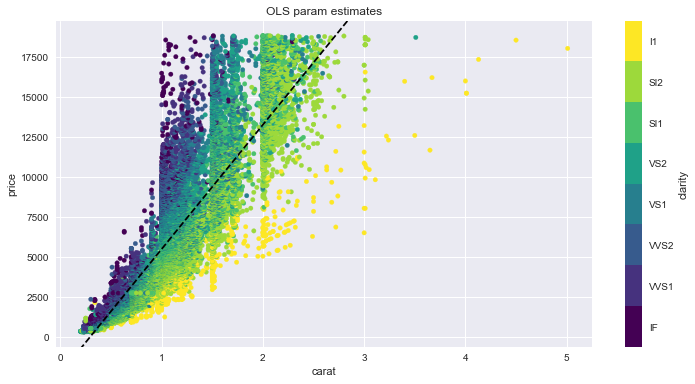

In [3]:
## OLS

fig, ax = plt.subplots(1,1,figsize=(12,6))
df.plot.scatter(y='price', x='carat', c='clarity', cmap='viridis', ax=ax)
ax.set(title='OLS param estimates', ylim=ax.get_ylim(), xlim=ax.get_xlim())

y, x = df.price, df[['const','carat']]

params = inv(x.T @ x) @ x.T @ y  ## beta = (X'X)^-1 X'Y
line(intercept=params[0], slope=params[1], ax=ax, linestyle='--', c='k')

print(f'b0={params[0]}\nb1={params[1]}')

## General gradient descent method:

GD coef updating formulae

$$\beta_{0, i} = \beta_{0, i-1} - \alpha \dfrac{\partial{SSE}}{\partial{\beta_{0,i-1}}} = \beta_{o, i-1} - -2\alpha\Sigma{y_{i} - \beta_{0, i-1} - \beta_{i, i-1}x_{i}}$$

and

$$\beta_{1, i} = \beta_{1, i-1} - \alpha \dfrac{\partial{SSE}}{\partial{\beta_{1,i-1}}} = \beta_{1, i-1} - -2\alpha\Sigma{(y_{i} - \beta_{0, i-1} - \beta_{1, i-1})x_{i-1}}$$

b0=-2256.360580045401
b1=7756.425617968433
iter=252


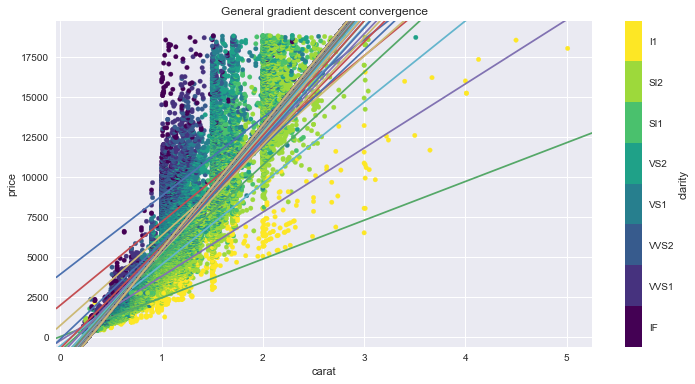

In [4]:
## General gradient descent method

# yield scatterplot of observations to depict gradual convergence
# using diamond prices in dollars, not ln(dollars), otherwise converges too quickly for demonstration
fig, ax = plt.subplots(1,1,figsize=(12,6))
df.plot.scatter(y='price', x='carat', c='clarity', cmap='viridis', ax=ax)
ax.set(title='General gradient descent convergence', ylim=ax.get_ylim(), xlim=ax.get_xlim())

b0 = b1 = 0
alpha = 1 / (2*len(y))        # learning rate (step size)
tolerence =  1E-8             # degree of precision desired, both derivatives must come this close to 0 
db0 = db1 = 1                 # init value to start while loop
loop_break = int(1E6)         # safety stop for loop, kill at X iterations
iter = 0                      # counter for iterations

y, x = df.price, df.carat

while abs(db0) > tolerence and abs(db1) > tolerence:
    db0 = -2*(y - (b1*x + b0)).sum()
    db1 = -2*(x*(y - (b1*x + b0))).sum()

    b0 -= alpha * db0
    b1 -= alpha * db1

    iter += 1

    if iter >= loop_break:
        print('Max iters reached, breaking loop')
        break

    if iter % 10:
        line(intercept=b0, slope=b1, ax=ax)

print(f'{b0=}\n{b1=}\n{iter=}')

## Newton-Raphson method:

Newton coef update formula
$$\beta_{1, i} = \beta_{1, i-1} - \dfrac{f'(x)}{f''(x)}$$

b0=-2256.360580045404
b1=7756.425617968435
iter=243


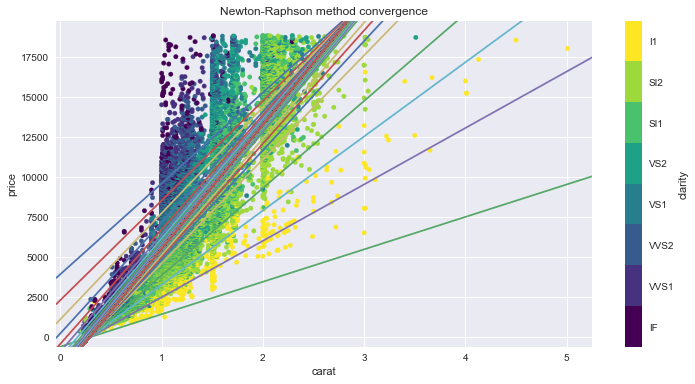

In [5]:
# yield scatterplot of observations to depict gradual convergence
# using diamond prices in dollars, not ln(dollars), otherwise converges too quickly for demonstration
fig, ax = plt.subplots(1,1,figsize=(12,6))
df.plot.scatter(y='price', x='carat', c='clarity', cmap='viridis', ax=ax)
ax.set(title='Newton-Raphson method convergence', ylim=ax.get_ylim(), xlim=ax.get_xlim())

b0 = b1 = 0
alpha = 1 / (2*len(y))        # learning rate (step size)
tolerence =  1E-8             # degree of precision desired, both derivatives must come this close to 0 
db0 = db1 = 1                 # init value to start while loop
loop_break = int(1E6)         # safety stop for loop, kill at X iterations
iter = 0                      # counter for iterations

y, x = df.price, df.carat

while abs(db0) > tolerence and abs(db1) > tolerence:
    db0 =-2*(y - (b1*x + b0)).sum()  # first derivatives
    db1 = -2*(x*(y - (b1*x + b0))).sum()  
    db0_2 = 2*len(y)  # 2nd derivatives
    db1_2 = 2*(x**2).sum()

    b0 -= (db0 / db0_2)
    b1 -= (db1 / db1_2)

    iter += 1

    if iter >= loop_break:
        print('Max iters reached, breaking loop')
        break

    if iter % 10:
        line(intercept=b0, slope=b1, ax=ax)

print(f'{b0=}\n{b1=}\n{iter=}')

## Some notes:
    - NR method perfroms marginally better than general gradient descent in convergence
    - General gradient descent does not require repeated calculation of sometimes computationally expensive second derivative, likely a better candidate for less well-behaved functions